In [38]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, to_timestamp, unix_timestamp, avg, lit
from pyspark.sql.functions import sum as _sum
from pyspark import SparkConf
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType

## Third Part
For the third part of the assignment, the metric that I've choosed tries to identify the period of quarantine (or how much time) people were keeping yourselfs at home, by tracking the number of tweets with the hashtag #stayathome. This metric will be calculated using the moving average, a statistic that captures the average change in a data series over time. The moving average of the number of tweets with #stayathome will be calculated over a week.

In [39]:
'''
spark = SparkSession.builder \
        .master("yarn") \
        .appName("HelloLines") \
        .getOrCreate()
sc = spark.sparkContext
rdd = sc.textFile("hdfs:/user/cunha/hello.txt")
'''
table_schema = StructType([
    StructField("account_created_at", StringType(), True),
    StructField("account_lang",   StringType(), True),
    StructField("country_code", StringType(), True),
    StructField("created_at", StringType(), True),
    StructField("favourites_count", StringType(), True),
    StructField("followers_count", StringType(), True),
    StructField("friends_count", StringType(), True),
    StructField("is_quote", StringType(), True),
    StructField("is_retweet", StringType(), True),
    StructField("lang", StringType(), True),
    StructField("place_full_name", StringType(), True),
    StructField("place_type", StringType(), True),
    StructField("reply_to_screen_name", StringType(), True),
    StructField("reply_to_status_id", StringType(), True),
    StructField("reply_to_user_id", StringType(), True),
    StructField("retweet_count", StringType(), True),
    StructField("screen_name", StringType(), True),
    StructField("source", StringType(), True),
    StructField("status_id", StringType(), True),
    StructField("text", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("verified", StringType(), True),
])

spark = SparkSession \
    .builder \
    .enableHiveSupport() \
    .config(conf=SparkConf().set("spark.driver.maxResultSize", "2g")) \
    .appName("stayathomeanalysis") \
    .getOrCreate()

spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

df = spark.read.json("../../database/2.json", schema=table_schema) # MUDAR O NOME AQUUUUIIII
df = df.select(col("created_at"), col("text"))
df.show()

+--------------------+--------------------+
|          created_at|                text|
+--------------------+--------------------+
|2020-03-31T00:00:00Z|Cuando mejor iban...|
|2020-03-31T00:00:00Z|Para prevenir el ...|
|2020-03-31T00:00:00Z|"▶ \"Es deseable ...|
|2020-03-31T00:00:00Z|“Tú eres tu parej...|
|2020-03-31T00:00:00Z|Los taxis tienen ...|
|2020-03-31T00:00:00Z|Sin futbol hasta ...|
|2020-03-31T00:00:00Z|Here are some tip...|
|2020-03-31T00:00:00Z|New York welcomes...|
|2020-03-31T00:00:00Z|#ConferenciaDePre...|
|2020-03-31T00:00:00Z|#كورونا يجبر #مجل...|
|2020-03-31T00:00:00Z|#Tamaulipas | Al ...|
|2020-03-31T00:00:00Z|💵 El ayuntamient...|
|2020-03-31T00:00:00Z|¿Eres mayor de 60...|
|2020-03-31T00:00:00Z|Es muy importante...|
|2020-03-31T00:00:00Z|Release Yemen det...|
|2020-03-31T00:00:00Z|แพทย์แนะดูแลผู้สู...|
|2020-03-31T00:00:00Z|       "\"Uulitin ko|
|2020-03-31T00:00:00Z|#Local Hay 12 dip...|
|2020-03-31T00:00:00Z|"#Fernandez lamen...|
|2020-03-31T00:00:00Z|#COVID19 | 

In [40]:
# Filtering by hashtag
hashtag = "#stayathome"
df = df.withColumn('unix_time', unix_timestamp('created_at', 'yyyy-MM-dd'))
filtered = df.filter(df.text.contains(hashtag))
filtered.show()

+--------------------+--------------------+----------+
|          created_at|                text| unix_time|
+--------------------+--------------------+----------+
|2020-03-31T00:03:04Z|@kevincorke Canad...|1585623600|
|2020-03-31T00:03:07Z|#unfollow4unfollo...|1585623600|
|2020-03-31T00:03:17Z|#ChicagoAlert #Ch...|1585623600|
|2020-03-31T00:04:20Z|Sigamos luchando ...|1585623600|
|2020-03-31T00:04:44Z|Italy will be the...|1585623600|
|2020-03-31T00:05:44Z|TERUSKAN BERDOA S...|1585623600|
|2020-03-31T00:08:49Z|#stayathome #covi...|1585623600|
|2020-03-31T00:09:41Z|#PMRKualaNerus #J...|1585623600|
|2020-03-31T00:11:19Z|#delivery #foodde...|1585623600|
|2020-03-31T00:11:20Z|COVID-19: State b...|1585623600|
|2020-03-31T00:13:33Z|Now On eBay!  2 k...|1585623600|
|2020-03-31T00:15:19Z|Me avoiding accid...|1585623600|
|2020-03-31T00:22:35Z|Give your support...|1585623600|
|2020-03-31T00:24:08Z|Police sweep #Jua...|1585623600|
|2020-03-31T00:24:24Z|@AMS_Landscaping ...|1585623600|
|2020-03-3

In [41]:
# Create a window
tweets_per_day = filtered.groupby("unix_time", "created_at").count()
window = Window.orderBy('unix_time').rangeBetween(-7*86400, 0)
tweets_per_day_rolling = tweets_per_day.withColumn('rolling_average', avg("count").over(window))
tweets_per_day_rolling.show()

22/05/13 22:36:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/13 22:36:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/13 22:36:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/13 22:36:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+--------------------+-----+------------------+
| unix_time|          created_at|count|   rolling_average|
+----------+--------------------+-----+------------------+
|1585623600|2020-03-31T00:46:57Z|    1|1.0102669404517455|
|1585623600|2020-03-31T00:56:39Z|    1|1.0102669404517455|
|1585623600|2020-03-31T00:56:34Z|    1|1.0102669404517455|
|1585623600|2020-03-31T00:57:56Z|    1|1.0102669404517455|
|1585623600|2020-03-31T00:43:06Z|    1|1.0102669404517455|
|1585623600|2020-03-31T00:56:00Z|    1|1.0102669404517455|
|1585623600|2020-03-31T00:24:08Z|    1|1.0102669404517455|
|1585623600|2020-03-31T00:03:17Z|    1|1.0102669404517455|
|1585623600|2020-03-31T00:43:37Z|    1|1.0102669404517455|
|1585623600|2020-03-31T00:38:03Z|    1|1.0102669404517455|
|1585623600|2020-03-31T00:05:44Z|    1|1.0102669404517455|
|1585623600|2020-03-31T00:30:22Z|    1|1.0102669404517455|
|1585623600|2020-03-31T00:50:13Z|    1|1.0102669404517455|
|1585623600|2020-03-31T00:58:01Z|    1|1.010266940451745

In [42]:
# remove those from the same day
tweets_per_day_rolling = tweets_per_day_rolling.drop_duplicates(["unix_time"])
tweets_per_day_rolling.show()

22/05/13 22:36:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/13 22:36:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/13 22:36:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+--------------------+-----+------------------+
| unix_time|          created_at|count|   rolling_average|
+----------+--------------------+-----+------------------+
|1585623600|2020-03-31T00:46:57Z|    1|1.0102669404517455|
+----------+--------------------+-----+------------------+



22/05/13 22:37:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/13 22:37:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/13 22:37:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


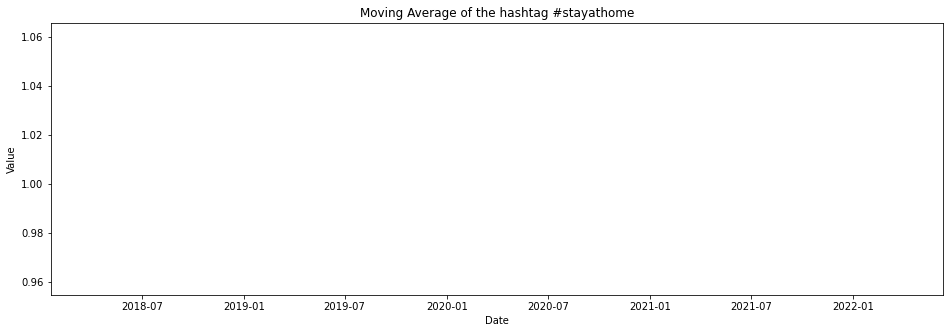

In [46]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value'):
    plt.figure(figsize=(16,5))
    plt.plot(x, y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.savefig('time-series.png')
    plt.show()

tweets_per_day_rolling = tweets_per_day_rolling.withColumn('day',  to_timestamp(col("unix_time")))
data = tweets_per_day_rolling.toPandas()
plot_df(data, x=data.day, y=data.rolling_average, title='Moving Average of the hashtag #stayathome')
